In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm
# from torch import datasets

from torch import _vmap_internals
from torchvision import datasets, transforms
# import torch.nn.functional as F

import pandas as pd

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost_xu
from cfollmer.sampler_utils import FollmerSDE
from cfollmer.drifts import *
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathrm{Bernouli}\left[\mathrm{NN}_{\theta}\left(x_i \right)\right]
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the iris dataset

In [3]:
images_train = datasets.MNIST("../data/mnist/", download=True, train=True)
images_test = datasets.MNIST("../data/mnist/", download=True, train=False)

transform = torch.nn.Sequential(transforms.Normalize((0.1307,), (0.3081)))

In [4]:
X_train, y_train = images_train.data, images_train.targets
X_test, y_test = images_test.data, images_test.targets

X_train = torch.flatten(transform(X_train.float()), 1)
X_test = torch.flatten(transform(X_test.float()), 1)

y_train = F.one_hot(y_train)
y_test = F.one_hot(y_test)

# X_train = np.concatenate((X_train, np.ones((X_train.shape[0],X_train.shape[1]))), axis=1)
# X_test = np.concatenate((X_test, np.ones((X_test.shape[0],X_train.shape[1]))), axis=1)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

<ipython-input-5-c969fd29504f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train, dtype=torch.float32, device=device), \
<ipython-input-5-c969fd29504f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test, dtype=torch.float32, device=device), \
<ipython-input-5-c969fd29504f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train, dtype=torch.float32, device=device), \
<ipython-input-5-c969fd29504f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

In [6]:
X_train.shape

torch.Size([60000, 784])

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [7]:
import torch.nn.functional as F


class ClassificationNetwork(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape
        
#         dim_bl =  sum([wx * wy + wy for wx, wy in self.shapes[:-1]])
#         Θ[:dim_bl] = (Θ[:dim_bl] - Θ[:dim_bl].mean()) / Θ[:dim_bl].std()
#         σ_Θ, μ_Θ = Θ.std(), Θ.mean()
#         Θ = (Θ - μ_Θ) / σ_Θ

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx), #* σ_Θ + μ_Θ,
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy) # * σ_Θ + μ_Θ
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds

In [8]:
dim = X_train.shape[1]
out_dim = y_train.shape[1]

net = ClassificationNetwork(
    dim, out_dim, device=device, depth=1, width=50, activation=F.tanh
)


def gaussian_prior(Θ, σ_w=3.8):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_vmap_nn(Θ, X, y, net=net):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    
    def loss(θ):
        preds = net.forward(X, θ)
        cel = torch.nn.CrossEntropyLoss(reduction="sum")
#         import pdb; pdb.set_trace()
        ll_cel = -1.0 * cel(preds, y.argmax(dim=1))
        return ll_cel
    
    batched_loss =  torch._vmap_internals.vmap(loss)

    return batched_loss(Θ)

In [9]:
net.dim

39760

In [10]:
class SimpleForwardNetBN_larger(AbstractDrift):

    def __init__(self, input_dim=1, width=300, activation=torch.nn.Softplus):
        super(SimpleForwardNetBN_larger, self).__init__()
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim )
        )
        
        self.nn[-1].weight.data.fill_(0.0)


γ =  0.1**2
Δt=0.01

dim= net.dim

prior = gaussian_prior

sde, losses = basic_batched_trainer(
    γ, Δt, prior, log_likelihood_vmap_nn, dim, X_train, y_train,
    method="euler", stl="stl_xu", adjoint=False, optimizer=None,
    num_steps=79, batch_size_data=int(X_train.shape[0] // 5), batch_size_Θ=30,
    batchnorm=True, device=device, lr=0.0001, drift=SimpleForwardNetBN_larger, schedule="uniform",
    γ_min= 0.1**2, γ_max= 0.4**2
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/local/scratch/home/fav25/ControlledFollmerDrift/cfollmer/objectives.py:143: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f = _vmap_internals.vmap(f_)
/local/scratch/home/fav25/ControlledFollmerDrift/cfollmer/objectives.py:144: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f_detached = _vmap_internals.vmap(sde.f_detached)
/local/scratch/home/fav25/ControlledFollmerDrift/cfollmer/objec

2.4022300243377686
2.2128050327301025
1.9833970069885254
1.6329466104507446
1.3610379695892334
1.1391723155975342
0.980584979057312
0.8404780030250549
0.7329635620117188
0.6571563482284546
0.5830343961715698
0.5209563970565796
0.5016452074050903
0.4762250781059265
0.45124584436416626
0.4096267521381378
0.40328866243362427
0.3922756016254425
0.36632657051086426
0.35734695196151733
0.3713151812553406
0.34074217081069946
0.3391034007072449
0.31357333064079285
0.3057865500450134
0.3094225525856018
0.3050806522369385
0.29477980732917786
0.3075468838214874
0.30766722559928894
0.2836025357246399
0.3036523461341858
0.29038694500923157
0.2780734896659851
0.27936920523643494
0.28309139609336853
0.2751404047012329
0.27318280935287476
0.2971305251121521
0.2868804931640625
0.26342684030532837
0.2614476978778839
0.29014554619789124
0.28242701292037964
0.2679479420185089
0.27000442147254944
0.273060142993927
0.2707056999206543
0.27386710047721863
0.28714215755462646
0.29627227783203125
0.262081831693

In [11]:
losses

[tensor(1.9185),
 tensor(0.8701),
 tensor(0.5066),
 tensor(0.3858),
 tensor(0.3341),
 tensor(0.3049),
 tensor(0.2870),
 tensor(0.2831),
 tensor(0.2731),
 tensor(0.2750),
 tensor(0.2735),
 tensor(0.2691),
 tensor(0.2523),
 tensor(0.2566),
 tensor(0.2520),
 tensor(0.2493),
 tensor(0.2537),
 tensor(0.2532),
 tensor(0.2622),
 tensor(0.2553),
 tensor(0.2440),
 tensor(0.2430),
 tensor(0.2255),
 tensor(0.2316),
 tensor(0.2392),
 tensor(0.2326),
 tensor(0.2265),
 tensor(0.2267),
 tensor(0.2272),
 tensor(0.2236),
 tensor(0.2207),
 tensor(0.2262),
 tensor(0.2163),
 tensor(0.2306),
 tensor(0.2296),
 tensor(0.2243),
 tensor(0.2182),
 tensor(0.2118),
 tensor(0.2217),
 tensor(0.2218),
 tensor(0.2278),
 tensor(0.2182),
 tensor(0.2251),
 tensor(0.2183),
 tensor(0.2205),
 tensor(0.2164),
 tensor(0.2090),
 tensor(0.2105),
 tensor(0.2098),
 tensor(0.2287),
 tensor(0.2242),
 tensor(0.2329),
 tensor(0.2258),
 tensor(0.2163),
 tensor(0.2033),
 tensor(0.2141),
 tensor(0.2205),
 tensor(0.2147),
 tensor(0.2140

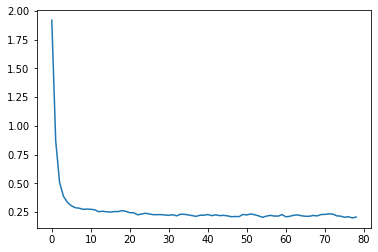

In [12]:
plt.plot(losses[:])

In [13]:
X_train.shape

torch.Size([60000, 784])

In [14]:
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 100
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device)

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 3.,  4.,  8.,  8., 10., 19., 17., 13., 13.,  5.]),
 array([-0.26206753, -0.2176878 , -0.17330807, -0.12892835, -0.08454862,
        -0.0401689 ,  0.00421083,  0.04859056,  0.09297028,  0.13735001,
         0.18172973], dtype=float32),
 <BarContainer object of 10 artists>)

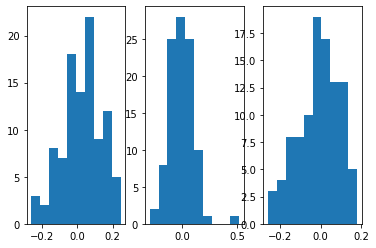

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [16]:
def predc(X, Θ):
    return torch.vstack([(net.forward(X, θ)[None,...]).softmax(dim=-1) for θ in Θ]).mean(dim=0)

In [17]:
pred = predc(X_train, Θ_1)

In [18]:
pred.shape

torch.Size([60000, 10])

In [19]:

((pred.argmax(dim=-1)).float().flatten()== y_train.argmax(dim=-1)).float().mean()

tensor(0.9394, device='cuda:0')

In [20]:
pred_test = predc(X_test.float(), Θ_1)

In [21]:
((pred_test.argmax(dim=-1)).float().flatten()== y_test.argmax(dim=-1)).float().mean()

tensor(0.9406, device='cuda:0')

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [ ]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
        print(loss_map.item())
        optimizer_map.step()
        losses_map.append(loss_map.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map